# Neu560 Final Project: Simulations

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

def rms(arr):
    return np.sqrt( np.mean( np.power(arr, 2) ) )

## Section 1: The Problem with Smoothing

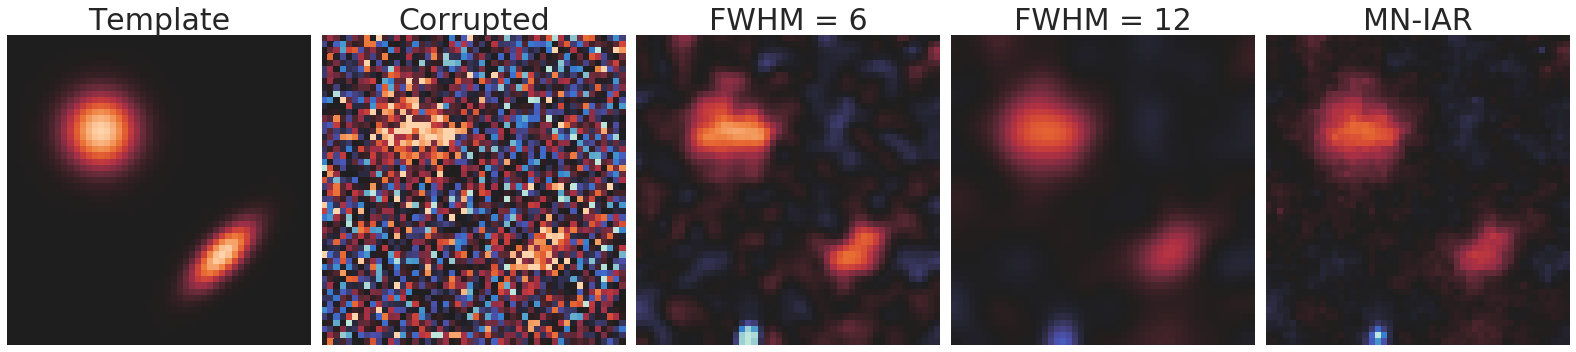

In [2]:
from scipy.stats import multivariate_normal, t
from scipy.ndimage.filters import gaussian_filter
from scripts.spm_hrf import spm_hrf
from scripts.matnormal import MatrixNormalCAR

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
nrow = ncol = 50
V = nrow * ncol

## Define SNR.
signal = 2.5
noise = 5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Sample data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define mesh.
xy = np.array(np.meshgrid(np.arange(nrow), np.arange(ncol)))
xy = xy.T.reshape(nrow*ncol,2)
V, D = xy.shape

## Define spatial template.
template = np.zeros(V)
blob = multivariate_normal(mean=[15,15],cov=20 * np.eye(2)).pdf(xy)
template += signal * (blob / blob.max())

blob = multivariate_normal(mean=[35,35],cov=15 * np.array([[1,-0.7],[-0.7,1]])).pdf(xy)
template += signal * (blob / blob.max())

## Define temporal template.
hrf = spm_hrf(1)
boxcars = np.zeros(250)
for onset in np.arange(10,250,40): boxcars[onset:onset+20] = 1
bold = np.convolve(boxcars, hrf)[:boxcars.size]
bold /= bold.max()

## Generate data.
Y = np.outer(bold, template)
Y += t(2.5,0,noise).rvs(size=Y.shape)

## Generate design matrix.
X = np.vstack([bold, np.ones_like(bold)]).T
X = bold.copy().reshape(-1,1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,5,figsize=(22,5))

## Plot template.
sns.heatmap(template.reshape(nrow,ncol), cbar=False, center=0, vmin=-2.5, vmax=2.5, 
            xticklabels=[], yticklabels=[], ax=axes[0])
axes[0].set_title('Template', fontsize=30)

## Plot OLS regression w/ varying smoothing.
for ax, fwhm in zip(axes[1:], [0, 3, 6]):
    
    ## Smooth.
    Ys = np.array([gaussian_filter(arr, fwhm2sigma(fwhm)) for arr in Y.reshape(-1, nrow, ncol).copy()])
    
    ## Regress.
    w, _, _, _ = np.linalg.lstsq(X, Ys.reshape(-1, V))
    
    ## Plot.
    sns.heatmap(w.reshape(nrow,ncol), cbar=False, center=0, vmin=-2.5, vmax=2.5, 
                xticklabels=[], yticklabels=[], ax=ax)
    if not fwhm: ax.set_title('Corrupted', fontsize=30)
    else: ax.set_title('FWHM = %s' %(fwhm*2), fontsize=30)
    
## IAR regression.
mn = MatrixNormalCAR()
D, A = mn.compute_graph_laplacian(xy)
W = mn.fit(Y, X, D, A)

## Plot.
sns.heatmap(W.reshape(nrow,ncol), cbar=False, center=0, vmin=-2.5, vmax=2.5, 
                xticklabels=[], yticklabels=[], ax=axes[-1])
axes[-1].set_title('MN-IAR', fontsize=30)

plt.tight_layout()
plt.savefig('plots/slide_3.png', dpi=180)

## Section 2: Parameter Recovery

In [3]:
from tqdm import tqdm
from pandas import DataFrame, Series
from sklearn.metrics import confusion_matrix

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Data parameters identical to above. Only
## setting the number of simulations here.
n_sim = False

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
roc = DataFrame([], columns=('Model','Threshold','TN','FP','FN','TP'))

for _ in tqdm(np.arange(n_sim)):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Simulate data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Define spatial template.
    template = np.zeros(V)
    for _ in np.arange(np.random.randint(2,5)):
        
        ## Sample blob parameters. 
        mean = np.random.uniform(5, 45, size=2)
        corr = np.random.uniform(-0.75, 0.75)
        ext =  np.random.uniform(5, 25, 1)
        act =  np.random.normal(signal, 0.25)
    
        ## Add to template.
        cov = ext * np.array([[1,corr],[corr,1]])
        blob = multivariate_normal(mean=mean, cov=cov).pdf(xy)
        template += act * (blob / blob.max())
    
    ## Generate data.
    Y = np.outer(bold, template)
    Y += t(2.5,0,noise).rvs(size=Y.shape)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Fit data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    for fwhm in [0, 3, 6, 'IAR']:
        
        if isinstance(fwhm, int):
        
            ## Smooth.
            Ys = np.array([gaussian_filter(arr, fwhm2sigma(fwhm)) for arr in Y.reshape(-1, nrow, ncol).copy()])

            ## Regress.
            w, _, _, _ = np.linalg.lstsq(X, Ys.reshape(-1, V))
            
        else:
            
            ## Fit IAR model.
            mn = MatrixNormalCAR()
            w = mn.fit(Y, X, D, A)
            if not mn.success: continue
        
        for i, thresh in enumerate(np.linspace(0.5, 2.0)):
    
            ## Compute confusion matrix.
            cm = confusion_matrix(template > thresh, w.squeeze() > thresh).astype(float)
            cm = np.divide(cm, cm.sum(axis=0), where=cm.sum(axis=0)>0)
            roc = roc.append(Series([fwhm, thresh] + cm.flatten().tolist(), 
                                    index=roc.columns), ignore_index=True)
            
# if n_sim: roc.to_csv('roc.csv', index=False)

0it [00:00, ?it/s]


### Plotting

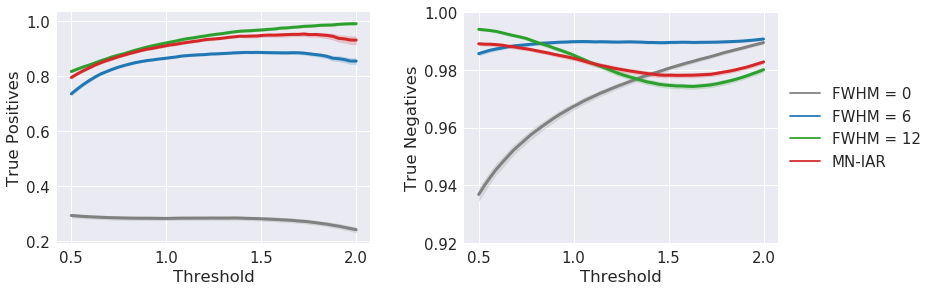

In [4]:
from pandas import Categorical, read_csv

## Load data.
roc = read_csv('roc.csv')

## Rename
roc['Model'] = Categorical(roc['Model'])
roc['Model'] = roc.Model.cat.rename_categories({'0.0':'FWHM = 0', '3.0':'FWHM = 6', 
                                                '6.0':'FWHM = 12', 'IAR':'MN-IAR'})

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(13,4))
palette = ['0.5', '#1f77b4', '#2ca02c', '#d62728']

## Plot true positives.
sns.lineplot('Threshold', 'TP', 'Model', data=roc, palette=palette, lw=3, ax=axes[0])
axes[0].set(ylabel='True Positives')
axes[0].legend_.set_visible(False)

## Plot true positives.
sns.lineplot('Threshold', 'TN', 'Model', data=roc, palette=palette, lw=3, ax=axes[1])
axes[1].set(ylim=(0.92, 1.0), ylabel='True Negatives')
axes[1].legend(loc=7, bbox_to_anchor=(1.5,0.5))

sns.despine()
plt.subplots_adjust(left=0.07, right=0.84, top=0.95, bottom=0.15, wspace=0.3)
plt.savefig('plots/slide_4.png', dpi=180)